In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect= True)
# reflect the tables


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
last_date = session.query(func.max(measurement.date)).all()
last_date 

[('2017-08-23')]

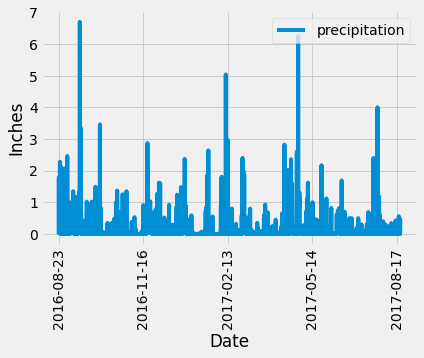

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
db_retrieve = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_measurement = pd.DataFrame(db_retrieve, columns=['date', 'precipitation'])

# Sort the dataframe by date
df_measurement = df_measurement.sort_values("date")
#noticed there were some Nan values in the DB. so Nan values were dropped 
df_measurement = df_measurement.dropna(how ='any')
df_measurement = df_measurement.reset_index(drop = True)


# Use Pandas Plotting with Matplotlib to plot the data
df_measurement.plot(x='date', y='precipitation')
plt.xticks(rotation = 90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc = 'upper right')



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_measurement.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

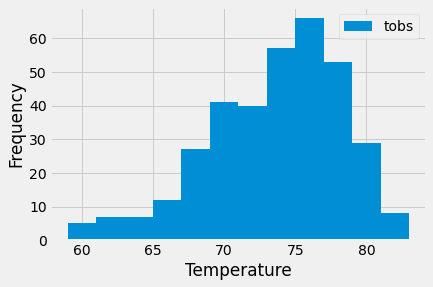

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# year_ago varaible was calculated previously.

#year_ago

results = session.query(measurement.tobs).filter(measurement.station =="USC00519281").\
    filter(measurement.date >= year_ago).all()

df_tobs = pd.DataFrame(results, columns=['tobs'])

#bins = 12 since there are 12 months.
df_tobs.plot(kind = 'hist', bins=12)
plt.xlabel("Temperature")




## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018,3,7) - dt.timedelta(days=365)
prev_year_end = dt.date(2018,3,21) - dt.timedelta(days=365)

tmin,tavg,tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin,tavg,tmax)

62.0 71.32608695652173 82.0


([], <a list of 0 Text major ticklabel objects>)

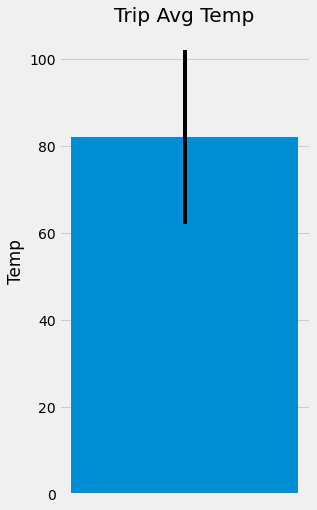

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2))
bar = ax.bar(1,tmax, yerr= tmax - tmin)
plt.title("Trip Avg Temp")
plt.ylabel("Temp")
#to match the example provided, passed an empty list to remove the x-ticks 
plt.xticks([])

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


total_rainfall = session.query(station.station,station.name, station.latitude, station.longitude, station.elevation).\
    filter(measurement.station == station.station).filter(measurement.date >= prev_year_start).\
    filter(measurement.date <=prev_year_end).group_by(station.name).order_by(func.sum(measurement.prcp).desc()).all()

total_rainfall

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
start = '2018-03-07'
end = '2018-3-21'
# Use the start and end date to create a range of dates
trip_tf = pd.date_range(start,end)

# Strip off the year and save a list of %m-%d strings
month_date_tf = trip_tf.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date

nrml = []

for date in month_date_tf:
    nrml.append(*daily_normals(date))

nrml

[(60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0),
 (60.0, 69.89285714285714, 82.0),
 (62.0, 69.88888888888889, 80.0),
 (56.0, 69.29629629629629, 77.0),
 (62.0, 70.32758620689656, 77.0),
 (58.0, 68.54716981132076, 76.0),
 (60.0, 69.70370370370371, 78.0),
 (57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0)]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_nrmls = pd.DataFrame(nrml, columns=["tmin","tavg","tmax"])
df_nrmls['date']= trip_tf
df_nrmls = df_nrmls.set_index(["date"])
df_nrmls

,tmin,tavg,tmax
date,,,
2018-03-07,60.0,69.172414,78.0
2018-03-08,59.0,68.724138,78.0
2018-03-09,57.0,68.561404,75.0
2018-03-10,57.0,69.122807,75.0
2018-03-11,60.0,69.892857,82.0
2018-03-12,62.0,69.888889,80.0
2018-03-13,56.0,69.296296,77.0
2018-03-14,62.0,70.327586,77.0
2018-03-15,58.0,68.547170,76.0


(-2.0, 90.0)

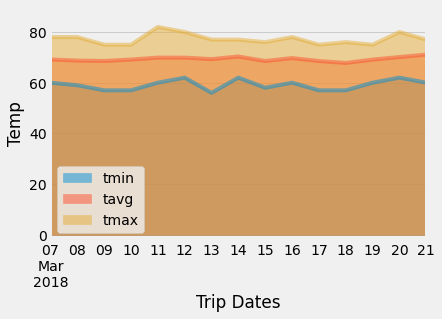

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
df_nrmls.plot(kind='area', stacked=False)
plt.xlabel("Trip Dates")
plt.ylabel("Temp")
plt.legend(loc= 'best')
#the lim was set to -2 instead of 0 because the x tick and y ticks were overlapping at 0
plt.ylim(-2,90)



In [34]:
session.close()